# Batch 0 Image Analysis with initial CMU Model 
### Setting up environment


In [23]:
# Instance Segmentation of Powder Particles and Satellites

#%%

## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

## ampis
ampis_root = Path('../../../')
sys.path.append(str(ampis_root))

## Collecting Data


In [24]:
from ampis import data_utils, visualize


EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
json_path_train = Path('..', 'data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_training_W3.4.json')  # path to training data
json_path_val = Path('..','data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_validation_W3.json')  # path to training data

assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [27]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 400  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 150  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.OUTPUT_DIR = str(Path('..', f'{EXPERIMENT_NAME}_output_auto','W3.0'))
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

## Analyzing Images
Runs trained model on all 17 images of batch-0

Annotating: S06_02_SE1_1250X73


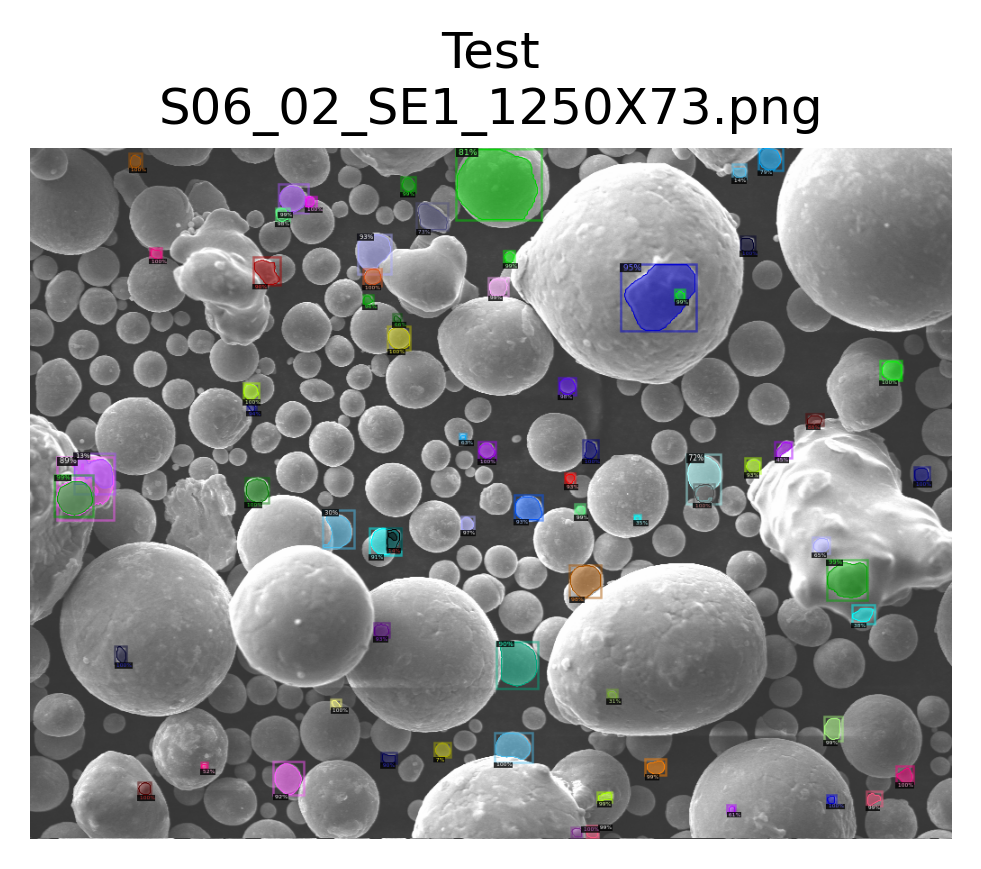

ddict info:
	path: ../data/test_images/S06_02_SE1_1250X73.png
	num_instances: 70
Annotating: S04_01_SE1_1250X44


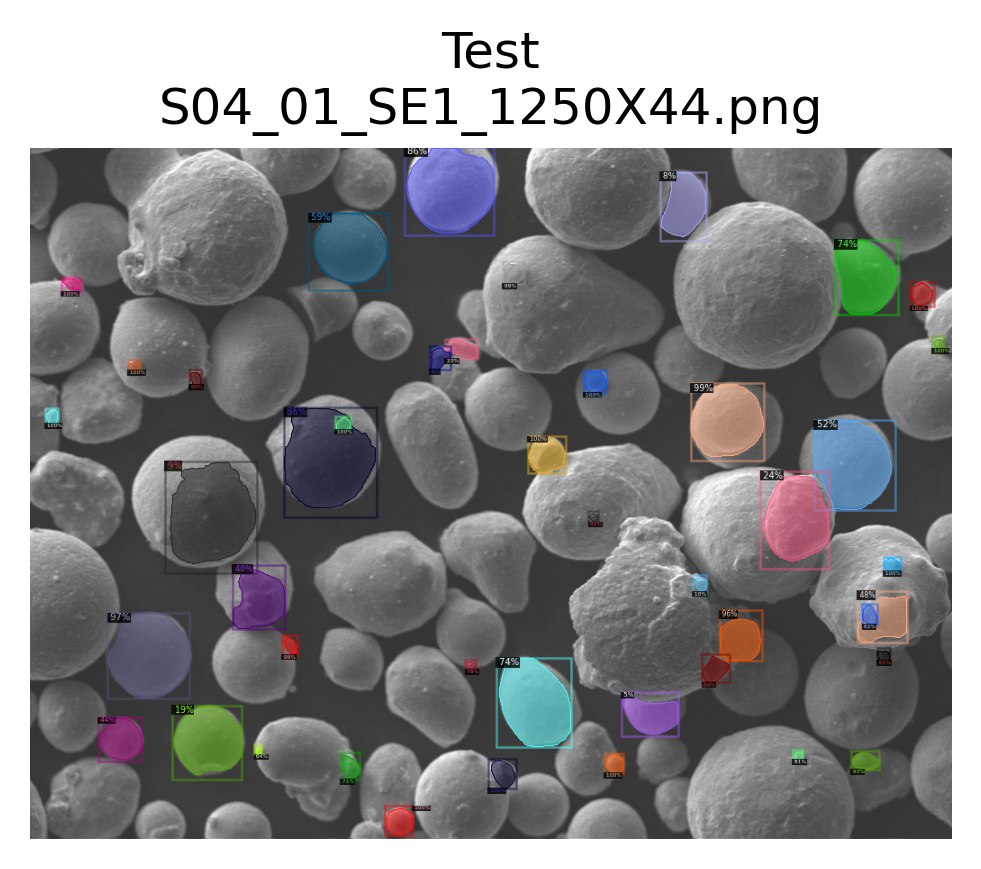

ddict info:
	path: ../data/test_images/S04_01_SE1_1250X44.png
	num_instances: 44
Annotating: S07_02_SE1_500X85


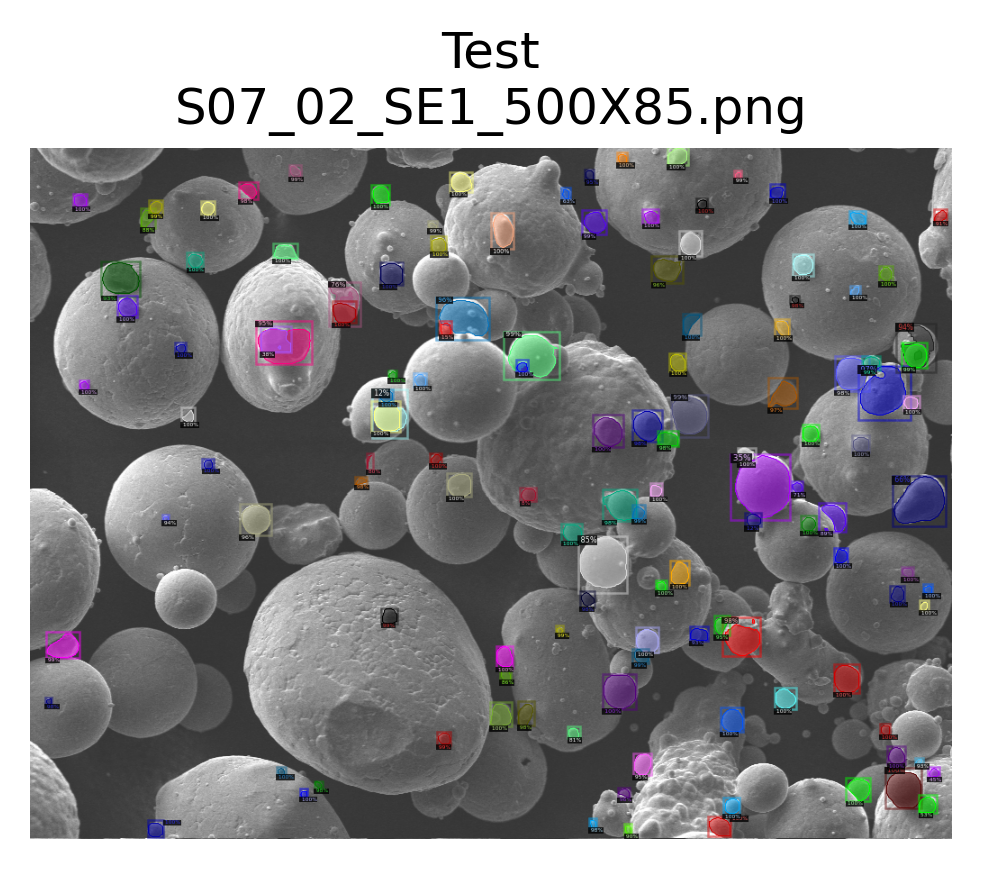

ddict info:
	path: ../data/test_images/S07_02_SE1_500X85.png
	num_instances: 129
Annotating: S02_01_SE1_1000X16


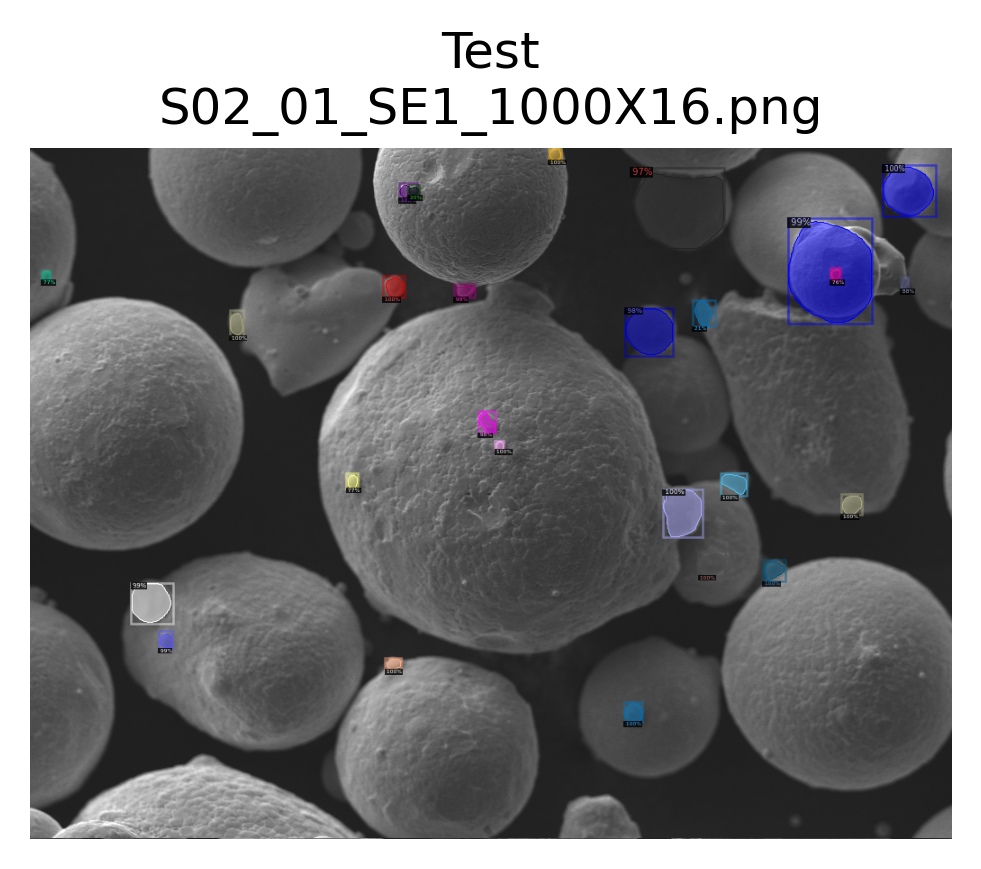

ddict info:
	path: ../data/test_images/S02_01_SE1_1000X16.png
	num_instances: 26
Annotating: S07_01_SE1_1000X79


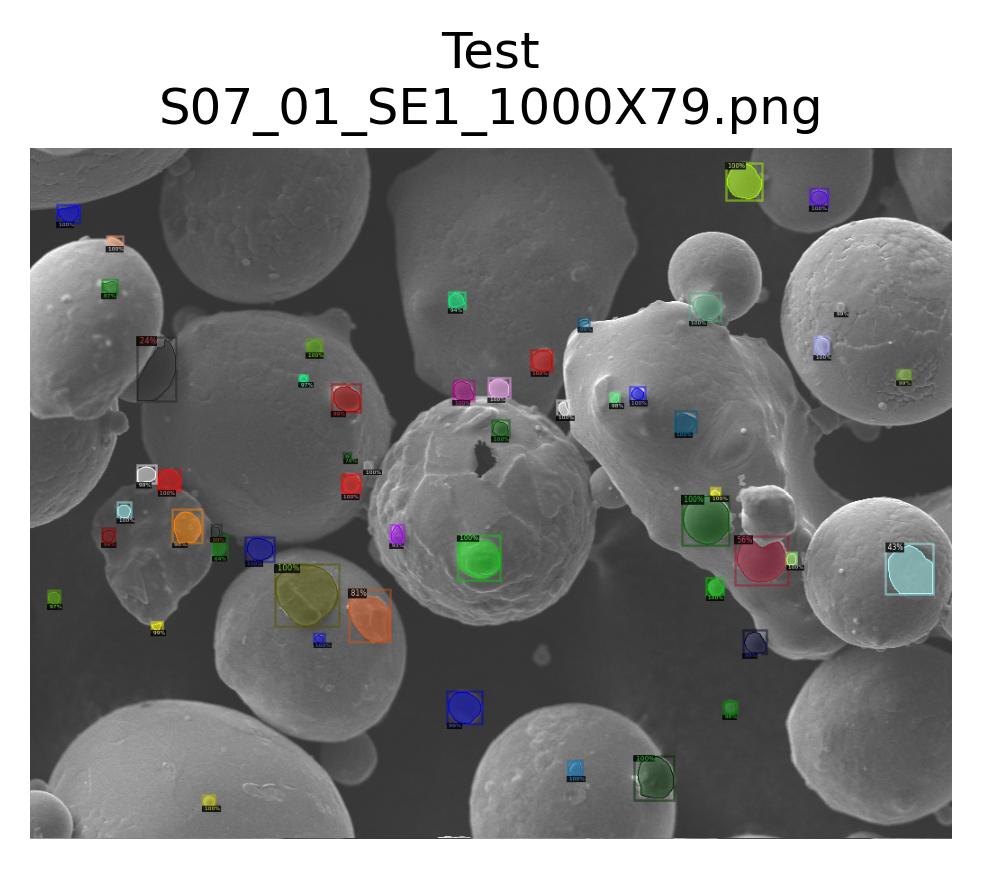

ddict info:
	path: ../data/test_images/S07_01_SE1_1000X79.png
	num_instances: 53
Annotating: S02_03_SE1_1000X24


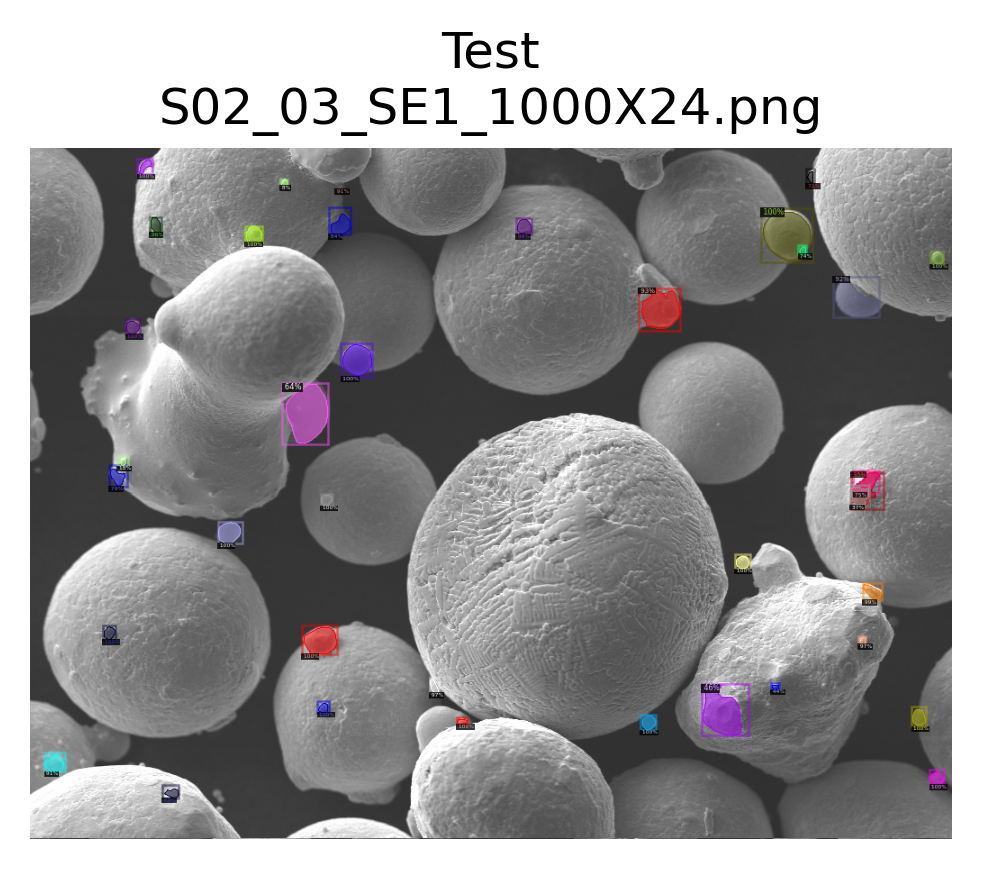

ddict info:
	path: ../data/test_images/S02_03_SE1_1000X24.png
	num_instances: 38


In [28]:
path = str(ampis_root) + '/examples/powder/data/test_images'
files = os.listdir(path)
img_names = []
for f in files:
    if f.split('.')[0] != 'README' and f.split('.')[0] != 'AMPIS-Images':
        img_names.append(f.split('.')[0])
    
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('..', 'data','test_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement